# Heat & Salinity Budgets — NEMO GYRE

- Surface heat flux (map and zonal mean)
- Total heat content time series
- Mean salinity time series (should be constant in a closed basin)

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

OUTPUT_DIR = Path("../output")
ds = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_T_0000.nc", decode_times=False
)
mm = xr.open_dataset(OUTPUT_DIR / "mesh_mask.nc")

tmask = mm["tmask"].isel(time_counter=0).values          # (z, y, x)
tmask_sfc = tmask[0]                                      # (y, x)
e1t = mm["e1t"].isel(time_counter=0).values               # (y, x) metres
e2t = mm["e2t"].isel(time_counter=0).values               # (y, x) metres
e3t = mm["e3t_1d"].isel(time_counter=0).values            # (z,)   metres
cell_area = e1t * e2t                                      # m^2

# Interior mask (exclude outermost ring)
interior = tmask_sfc.copy()
interior[0, :] = 0
interior[-1, :] = 0
interior[:, 0] = 0
interior[:, -1] = 0

# Cartopy projection
MARGIN = 4
lon, lat = ds.nav_lon.values, ds.nav_lat.values
proj = ccrs.Stereographic(central_longitude=-68, central_latitude=32)
extent = [lon.min() - MARGIN, lon.max() + MARGIN,
          lat.min() - MARGIN, lat.max() + MARGIN]

time_days = (ds.time_counter.values - ds.time_counter.values[0]) / 86400.0
print(f"Cell area sample: {cell_area[10,10]:.0f} m^2")
print(f"Vertical levels: {len(e3t)}, total depth: {e3t.sum():.0f} m")

Cell area sample: 11236000000 m^2
Vertical levels: 31, total depth: 4602 m


## Surface heat flux — map

Time-mean net downward heat flux (`sohefldo`, W/m²). Positive = ocean
gains heat. Expect heating in the subtropics and cooling at higher
latitudes.

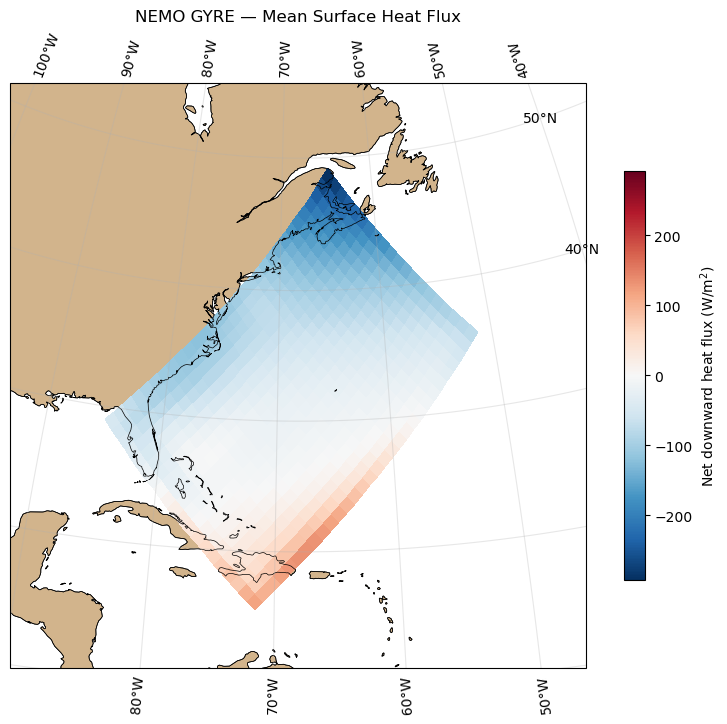

In [2]:
hflx = ds["sohefldo"].mean("time_counter").values
hflx_masked = np.where(interior, hflx, np.nan)

vmax = np.nanmax(np.abs(hflx_masked))

fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(projection=proj))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="tan", edgecolor="k", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.3)

pcm = ax.pcolormesh(
    lon, lat, hflx_masked, shading="auto", cmap="RdBu_r",
    vmin=-vmax, vmax=vmax, transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="Net downward heat flux (W/m$^2$)", shrink=0.7)
ax.set_title("NEMO GYRE — Mean Surface Heat Flux")
fig.tight_layout()

## Surface heat flux — zonal mean

Zonally averaged heat flux as a function of latitude.

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_68777/3354628937.py:2: RuntimeWarning: Mean of empty slice
  hflx_zonal = np.nanmean(hflx_masked_nan, axis=1)


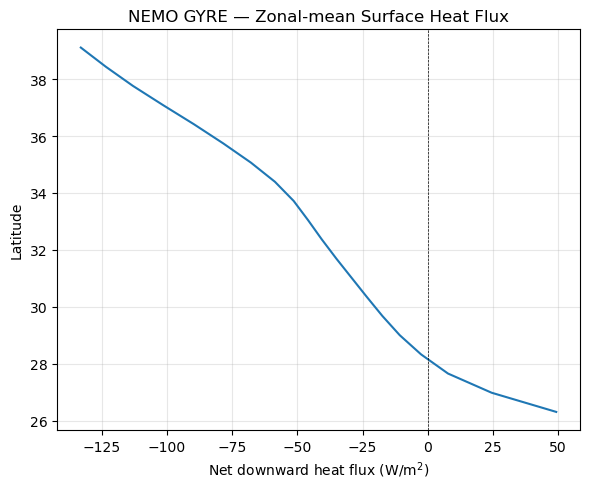

In [3]:
hflx_masked_nan = np.where(interior, hflx, np.nan)
hflx_zonal = np.nanmean(hflx_masked_nan, axis=1)
lat_mid = lat[:, lat.shape[1] // 2]
valid = ~np.isnan(hflx_zonal)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(hflx_zonal[valid], lat_mid[valid])
ax.axvline(0, color="k", linewidth=0.5, linestyle="--")
ax.set_xlabel("Net downward heat flux (W/m$^2$)")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Zonal-mean Surface Heat Flux")
ax.grid(True, alpha=0.3)
fig.tight_layout()

## Total heat content time series

Volume-integrated ocean heat content: $H = \rho_0\, c_p \sum_{i,j,k}
T_{i,j,k}\, e1t_i\, e2t_j\, e3t_k\, \text{tmask}_{i,j,k}$

Using $\rho_0 = 1026$ kg/m³ and $c_p = 3991$ J/(kg·K).

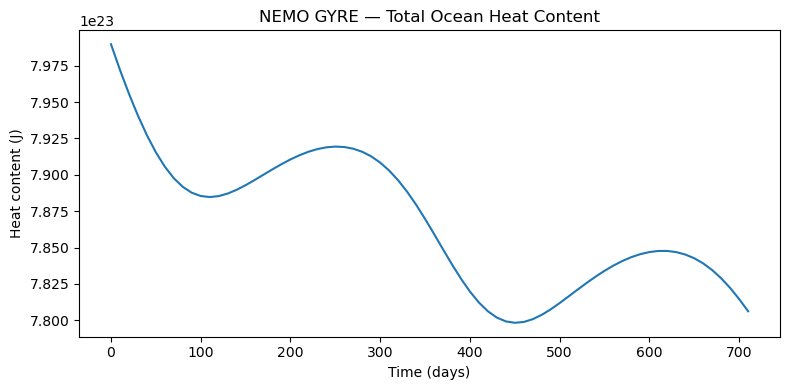

In [4]:
rho0 = 1026.0   # kg/m^3
cp   = 3991.0    # J/(kg K)

temp = ds["votemper"].values  # (t, z, y, x)

# Cell volume: e1t(y,x) * e2t(y,x) * e3t(z) * tmask(z,y,x)
cell_vol = cell_area[np.newaxis, :, :] * e3t[:, np.newaxis, np.newaxis] * tmask  # (z, y, x)

# Heat content at each time step
hc = np.array([
    rho0 * cp * np.sum(temp[t] * cell_vol)
    for t in range(temp.shape[0])
])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_days, hc)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Heat content (J)")
ax.set_title("NEMO GYRE — Total Ocean Heat Content")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
fig.tight_layout()

## Mean salinity time series

Volume-weighted mean salinity. In a closed basin with no freshwater
flux boundary, total salt should be conserved — the mean salinity
should stay constant.

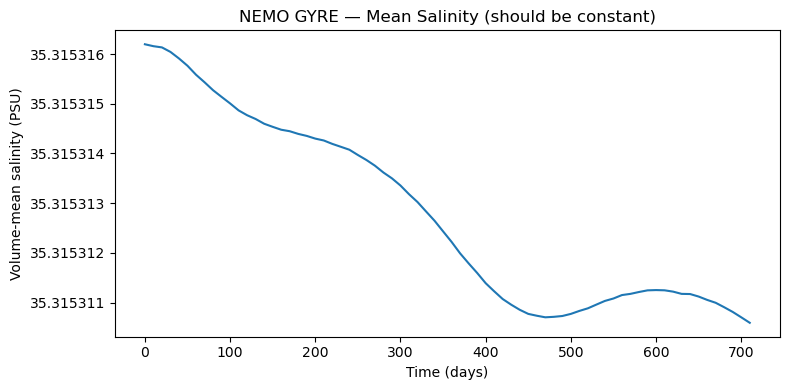

In [5]:
sal = ds["vosaline"].values  # (t, z, y, x)
total_vol = cell_vol.sum()

sal_mean = np.array([
    np.sum(sal[t] * cell_vol) / total_vol
    for t in range(sal.shape[0])
])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_days, sal_mean)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Volume-mean salinity (PSU)")
ax.set_title("NEMO GYRE — Mean Salinity (should be constant)")
ax.ticklabel_format(axis="y", useOffset=False)
fig.tight_layout()